# DROP ROBOT FROM MODEKLS

# Models Training

In [1]:
%%time

import os
import math
import datetime
import numpy as np
import pandas as pd
from copy import copy
from tqdm import tqdm

# Dictionaries
import json
from pprint import pprint

# Iterate in loops
import itertools
from itertools import zip_longest

# Simpsons integration
from numpy import trapz
from scipy.integrate import simps

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

Wall time: 2.56 s


In [2]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance

In [3]:
# Prints the current working directory
os.getcwd()
# os.listdir()

'C:\\Users\\fahad\\MegaSync\\NMBU\\GitHub\\vPheno'

## Finding Username folder to make general path for multi PC use

In [4]:
username = str(os.getcwd()).split('\\')[2]
user_path = r'C:/Users/'+username+'/'
username, user_path

('fahad', 'C:/Users/fahad/')

## Importing Data

In [5]:
main_path = r'./Data/'
path = r'./Data/results/temp_data/'
export_path = './Data/results/'

# Create export_path folder if not exists already
os.makedirs(path, exist_ok=True)
os.makedirs(export_path, exist_ok=True)

os.listdir(path)

['Graminor_2019_Simps.csv',
 'Masbasis_2019_Simps.csv',
 'Masbasis_2020_Simps.csv',
 'Robot_2020_Simps.csv']

## Data Preparation
### Creating list of complete files

In [6]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files found in the directory')
# files_with_address
files_list

4 files found in the directory


['Graminor_2019_Simps.csv',
 'Masbasis_2019_Simps.csv',
 'Masbasis_2020_Simps.csv',
 'Robot_2020_Simps.csv']

## Data Checking/control

### Check for duplicate filenames

In [7]:
print('Total number of files are :', len(files_list))

print('Number of unique file names are:', len(set(files_list)))

print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError

Total number of files are : 4
Number of unique file names are: 4
There is/are 0 duplicate file name/names.


## Importing data files to Pandas

In [8]:
   
%%time

all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("-", "_")
    file_name = file_name.replace(")", "")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(".", "")
    # Test: Check if the same date is already present in the current dict key
    if df_name in all_df:
        print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
        raise NameError
    all_df.append(df_name)

    locals()[df_name] = pd.read_csv(data, index_col=False)
    print(df_name, '=====', locals()[df_name].shape)
# all_df

Graminor_2019_Simps ===== (601, 7)
Masbasis_2019_Simps ===== (528, 7)
Masbasis_2020_Simps ===== (688, 7)
Robot_2020_Simps ===== (96, 7)
Wall time: 27.8 ms


In [9]:
print(f'Total imported {len(all_df)}')
all_df

Total imported 4


['Graminor_2019_Simps',
 'Masbasis_2019_Simps',
 'Masbasis_2020_Simps',
 'Robot_2020_Simps']

# Finding yield columns

In [10]:
# ToDo: Add check for duplicate columns in the df

general_col_names = ['Plot_ID', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR']

# list_agg_df
yield_cols = ['GrainYield', 'Days2Heading', 'Days2Maturity']
id_cols_new = ['Plot_ID']

# Counter for location of column in columns list

# Dict for saving the name and location of the yield column/s
loc_yield_cols = {}
for df in all_df:
    loc = 0
    for cols in locals()[df].columns.tolist():
        for y_col in yield_cols:
            if not cols.find(y_col):
                loc_yield_cols[cols+'_'+df] = loc
                print(f'\"{cols}\" column in {df} is the yield column\n as it contains the text \"{y_col}\". It is located at location {loc}')
        loc += 1

    yield_cols_found = list(loc_yield_cols.keys())
    target_cols=yield_cols_found[0]
loc_yield_cols

"GrainYield" column in Graminor_2019_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 6
"GrainYield" column in Masbasis_2019_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 6
"GrainYield" column in Masbasis_2020_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 6
"GrainYield" column in Robot_2020_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 6


{'GrainYield_Graminor_2019_Simps': 6,
 'GrainYield_Masbasis_2019_Simps': 6,
 'GrainYield_Masbasis_2020_Simps': 6,
 'GrainYield_Robot_2020_Simps': 6}

# Preprocessing 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
# import xgboost as xgb
from sklearn.linear_model import Lasso
# from catboost import CatBoostRegressor

import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## Importing declared functions

In [12]:
from functions.plot_feature_importance import plot_feature_importance
from functions.grid_search import grid
from functions.test_data_regression import test_data_regression

## Running imported function

In [13]:
import multiprocessing
multiprocessing.cpu_count()

import psutil
psutil.cpu_count()

8

## List of models

In [14]:
models = [GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500),
#          CatBoostRegressor(depth=8),
         RandomForestRegressor(random_state=1, n_jobs = -1)]
         


## Temp Preparation

In [18]:
# Iterating through all possible permutations of the fields dataset
results = []
for i in itertools.permutations(all_df, 2):

    train_df = locals()[i[0]].copy()
    test_df = locals()[i[1]].copy()
    
    print(f"Train dataset: {i[0]} {train_df['GrainYield'].isna().sum()}\
    \n Test dataset: {i[1]} {test_df['GrainYield'].isna().sum()}")
    print('=>')
#     print(f"Missing values in {i[0]} {train_df['GrainYield'].isna().sum()}\
#     \n Missing values in {i[1]} {test_df['GrainYield'].isna().sum()}")
    # Dropping entries with grainyield missing
    train_df.dropna(subset=['GrainYield'], inplace=True)
    test_df.dropna(subset=['GrainYield'], inplace=True)

    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, y_train, = train_df[[x for x in train_df.columns if x not in yield_cols+id_cols_new]], train_df['GrainYield']
    X_test, y_test = test_df[[x for x in test_df.columns if x not in yield_cols+id_cols_new]], test_df['GrainYield']
    features = X_train.columns

    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    for model in models:
        print(model)
        acc, acc_std, imp, imp_std = test_data_regression(model, features, X_train, X_train_std, y_train, X_test, X_test_std, y_test)
        results.append([i[0], i[1], model, acc, acc_std, imp, imp_std])
        print('=============================================')

Train dataset: Graminor_2019_Simps 1    
 Test dataset: Masbasis_2019_Simps 6
=>
GradientBoostingRegressor(learning_rate=0.4, random_state=500, subsample=0.8)
{   'MSE': 7998.4845900845485,
    'RMSE': 89.43424729981545,
    'R2 Score': -0.124968981885629}
RandomForestRegressor(n_jobs=-1, random_state=1)
{   'MSE': 6279.683122701575,
    'RMSE': 79.24445168402374,
    'R2 Score': 0.11677660317461691}
Train dataset: Graminor_2019_Simps 1    
 Test dataset: Masbasis_2020_Simps 117
=>
GradientBoostingRegressor(learning_rate=0.4, random_state=500, subsample=0.8)
{   'MSE': 14745.175214570987,
    'RMSE': 121.4297130630349,
    'R2 Score': -0.3915114907483155}
RandomForestRegressor(n_jobs=-1, random_state=1)
{   'MSE': 14019.868879626256,
    'RMSE': 118.40552723427338,
    'R2 Score': -0.32306387417535065}
Train dataset: Graminor_2019_Simps 1    
 Test dataset: Robot_2020_Simps 0
=>
GradientBoostingRegressor(learning_rate=0.4, random_state=500, subsample=0.8)
{   'MSE': 8737.236021104965,


In [22]:
train_dfs = [x[0] for x in results]
test_dfs = [x[1] for x in results]
modelss = [x[2] for x in results]
acc_normal = [x[3] for x in results]
acc_stds = [x[4] for x in results]
imp_normal = [x[5] for x in results]
imp_stds = [x[6] for x in results]
# acc_normal

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

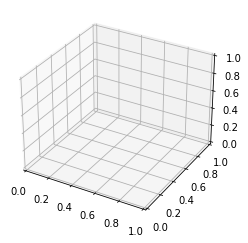

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y = train_dfs, test_dfs
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
# xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

In [48]:
temp_df = Robot_2020_Simps.copy()
#==============================================================================
# Dropping rows with missing values
#==============================================================================

temp_df.dropna(subset=['GrainYield'], inplace=True)
#==============================================================================
# Split dataframe into data and target
#==============================================================================
X = temp_df[[x for x in temp_df.columns if x not in yield_cols+id_cols_new]]
y = temp_df['GrainYield']

#==============================================================================
# Create separate train/test splits from Main data
#==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=55)

#==============================================================================
# Scale features using StandardScaler class in scikit-learn 
#==============================================================================

# Initialise standard scaler and compute mean and STD from training data
sc = StandardScaler()
sc.fit(X_train)

# Transform (standardise) both X_train and X_test with mean and STD from
# training data
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Wall time: 0 ns
4622.957956091049  mean_squared_error
67.99233748071211  root_mean_squared_error
0.5318637828980128  r2_score
{   'MSE': 4622.957956091049,
    'RMSE': 67.99233748071211,
    'R2 Score': 0.5318637828980128}


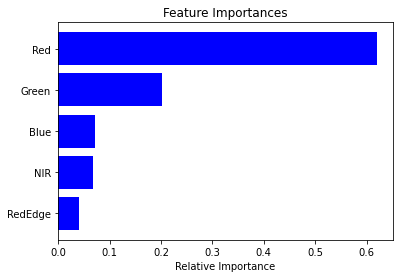

11130.99549980016  mean_squared_error
105.50353311524766  root_mean_squared_error
-0.12716191134511434  r2_score
{   'MSE': 11130.99549980016,
    'RMSE': 105.50353311524766,
    'R2 Score': -0.12716191134511434}


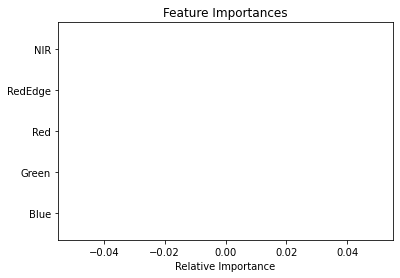

In [16]:
%time

cv = 10
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

time_taken = []
t_start=time.time()

#==============================================================================
# Create separate train/test splits
#==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=5)
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
#==============================================================================
# Training best performing models
#==============================================================================
#==============================================================================
# Finding out feature importance
#==============================================================================

model = RandomForestRegressor(n_estimators = 1000, max_depth=250, min_samples_split=5, random_state=0, n_jobs = -1)
model.fit(X_train, y_train)
# Finding feature importance
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)
# Running predictions
test_data_regression(model, X, X_test, y_test)
# Plotting feature importance
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



model = RandomForestRegressor(n_estimators = 50, max_depth=100, min_samples_split=400, random_state=0, n_jobs = -1)
model.fit(X_train, y_train)
# Finding feature importance
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)
# Running predictions
test_data_regression(model, X, X_test, y_test)
# Plotting feature importance
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Several Models: To clean

In [26]:
#==============================================================================
# Ridge
#==============================================================================
from sklearn.linear_model import Ridge
model = Ridge()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*1. for x in range(1,10)],
                  'model__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# Lasso
#==============================================================================
from sklearn.linear_model import Lasso
model = Lasso()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*0.1 for x in range(1,10)],
                  'model__max_iter' : [x for x in range(50, 10000, 50)],
                  'model__selection' : ['cyclic','random']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# ElasticNet
#==============================================================================
from sklearn.linear_model import ElasticNet
model = ElasticNet()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*0.1 for x in range(1,10)],
                  'model__max_iter' : [x for x in range(50, 10000, 50)],
                  'model__l1_ratio' : [x*0.1 for x in range(1,10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# OrthogonalMatchingPursuit
#==============================================================================
from sklearn.linear_model import OrthogonalMatchingPursuit
model = OrthogonalMatchingPursuit()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__fit_intercept' : [True, False],
                  'model__n_nonzero_coefs' : [x for x in range(1,10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# BayesianRidge
#==============================================================================
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_iter' : [x for x in range(5, 150, 10)],
                  'model__alpha_1' : [1.0],
                  'model__alpha_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_1' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_2' : [1.0]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# ARDRegression
#==============================================================================
from sklearn.linear_model import ARDRegression
model = ARDRegression()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_iter' : [x for x in range(5, 150, 10)],
                  'model__alpha_1' : [1.0],
#                       'model__alpha_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_1' : [0.01],
                  'model__lambda_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__verbose' : [True]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# RANSACRegressor
#==============================================================================
from sklearn.linear_model import RANSACRegressor
model = RANSACRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__min_samples' : [x/.1 for x in range(1, 10)],
                  'model__max_trials' : [x for x in range(1, 500,50)],
                  'model__loss' : ['absolute_loss', 'squared_loss']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# TheilSenRegressor
#==============================================================================
# from sklearn.linear_model import TheilSenRegressor
# model = TheilSenRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__max_subpopulation' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
#                   'model__n_subsamples' : [x for x in range(9, 1300,50)],
#                   'model__max_iter' :  [x for x in range(50, 1000, 50)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
#==============================================================================
# HuberRegressor
#==============================================================================
from sklearn.linear_model import HuberRegressor
model = HuberRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__epsilon' : [x/.01 for x in range(100, 200, 5)],
                  'model__alpha' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# DecisionTreeRegressor
#==============================================================================
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__max_depth' : [None]+[x for x in range(1, 100,5)],
                  'model__min_samples_leaf' : [x for x in range(1, 50,5)],
                  'model__min_samples_split' : [2]+[x for x in range(1, 50,5)],
                  'model__max_features' : [x for x in range(1, 10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# GaussianProcessRegressor
#==============================================================================
from sklearn.gaussian_process import GaussianProcessRegressor
model = GaussianProcessRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__kernel' : [None]+['rbf', 'sigmoid',  'linear', 'poly'],
                  'model__alpha' : [x*0.0000000001 for x in [1,10,100,1000,10000,100000,1000000]]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# KNeighborsRegressor
#==============================================================================
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_neighbors' : [x for x in range(1, 100,5)],
                  'model__weights' : ['uniform', 'distance'],
                  'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'model__leaf_size' : [x for x in range(10, 50, 5)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
# #==============================================================================
# # RadiusNeighborsRegressor
# #==============================================================================
# from sklearn.neighbors import RadiusNeighborsRegressor
# model = RadiusNeighborsRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
# #==============================================================================
# # RandomForestRegressor
# #==============================================================================
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
# #==============================================================================
# # SVR
# #==============================================================================
# from sklearn.svm import SVR
# model = SVR()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)

t_end = time.time()
tt = t_end - t_start
time_taken.append(tt)
print('Total time complete: ', (tt) / 60, 'minutes')

Wall time: 0 ns


NameError: name 'comments' is not defined

## Gradient Boosting Regressor Grid Search Params

In [ ]:
%time

import time, datetime
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

comments.append('Converted dates to ordinal.')
comments.append('Plot ID Dropped.')

comments.append('Test train split. test_Size=0.3, random_state=55')
cv = 10
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']


#==============================================================================
# GradientBoostingRegressor
#==============================================================================
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__loss' : ['ls', 'lad', 'huber', 'quantile'],
# #                   'model__learning_rate' : [0.001, 0.01, 0.1, 1],
# #                   'model__n_estimators' : range(0,500, 100),
                  
# #                   'model__max_depth':range(5,16,2), 
# #                   'model__min_samples_split':range(200,1100, 200), # 2100
# #                   'model__min_samples_leaf':range(30,71,10),
#                   'model__max_features':range(7,20,2),
#                   'model__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}]

param_grid   =  [{'model__loss' : ['huber'],
#                   'model__learning_rate' : [0.001, 0.01, 0.1, 1],
#                   'model__n_estimators' : range(0,500, 100),
                  
                  'model__max_depth':range(5,16,2), 
#                   'model__min_samples_split':range(2,5), # 2100
#                   'model__min_samples_leaf':range(1,2),
#                   'model__max_features':range(5,6),
                  'model__subsample':[0.7,0.8]}]
# pipe.get_params()
estimator = pipe

for score in scores:
    grid(Xtrain = X.values,
                ytrain = y.values,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)

## Random Forest Grid Search Params

In [ ]:
%time

import time, datetime
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

comments.append('Converted dates to ordinal.')
comments.append('Plot ID Dropped.')
comments.append('Test train split. test_Size=0.3, random_state=55')
cv = 5
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

#==============================================================================
# RandomForestRegressor
#==============================================================================
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {
    'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}


estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)

## Permutation importance

In [ ]:


# PERMUTATION

from sklearn.inspection import permutation_importance


result = permutation_importance(gs_xgb_fitted, X_test, y_test, n_repeats=100, random_state=0)

# ==================================
# Feature selection
# ===================================

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

# Plot importances
fig, ax = plt.subplots(figsize=(25, 25))
ind = indices = np.argsort(result.importances_mean)[::-1]
plt.barh(X_test.columns, result.importances_mean[ind])
plt.show()


In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1': make_scorer(f1_score, average = 'macro')}
grid_search_rfc = GridSearchCV(rfc, param_grid = grid_values, scoring = scoring, refit='f1')
grid_search_rfc.fit(x_train, y_train)

grid_search_rfc.best_params_
grid_search_rfc.cv_results_

# cv_results[‘mean_test_<metric_name>’]
grid_search_rfc.cv_results_['mean_test_recall']


## List of models

In [14]:
models = [GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500),
#          CatBoostRegressor(depth=8),
         RandomForestRegressor(max_depth=250, min_samples_split=14,min_samples_leaf =3, random_state=1, n_jobs = -1),
         Lasso(alpha= 4.5),
        ]
         


In [17]:
for df in all_df:
    
    
    temp_df = locals()[df].copy()
    #==============================================================================
    # Dropping rows with missing values
    #==============================================================================

    temp_df.dropna(subset=['GrainYield'], inplace=True)
    #==============================================================================
    # Split dataframe into data and target
    #==============================================================================
    X = temp_df[[x for x in temp_df.columns if x not in yield_cols+id_cols_new]]
    y = temp_df['GrainYield']
    
    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=55)
    
    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    #==============================================================================
    # Correlation heatmap of indices with target_cols
    #==============================================================================
#     sns.diverging_palette(331, 129, as_cmap=True)

#     pal=['PRGn', 'PiYG', 'PuOr', 'RdBu','RdYlBu','RdYlGn','Spectral']

#     correlation = temp_df.iloc[:,1:].corr()
#     matrix = np.triu(correlation)

#     plt.figure(figsize=(10,6))
#     plt.title(df)
#     sns.heatmap(correlation, cmap='PRGn', annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0 ,square=True, mask=matrix)
#     # plt.savefig('Data/heatmap.pdf',dpi=500, bbox_inches='tight')
#     plt.show()


    #==============================================================================
    # Predictions
    #==============================================================================

    param=[x/10 for x in range(25,100)]
    param=[x for x in range(0,1000, 100)]
    param=[1]
    for pr in tqdm(param):
        for model in models:
            R2 = []
            RMSE=[]
            MAE=[]
            for rs in range(10):
                #==============================================================================
                # Create separate train/test splits
                #==============================================================================
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
                X_train.reset_index(drop=True, inplace=True)
                X_test.reset_index(drop=True, inplace=True)
                sc = StandardScaler()
                sc.fit(X_train)
                X_train_std = sc.transform(X_train)
                X_test_std = sc.transform(X_test)
                #==============================================================================
                # Training best performing models
                #==============================================================================
    #             model = Lasso(alpha= 4.5)
                model.fit(X_train_std, y_train)
                y_pred = model.predict(X_test_std)
                R2.append(r2_score(y_test, y_pred))
                MAE.append(mean_absolute_error(y_test, y_pred))
                RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
            accuracy = {}
            accuracy['R2'] = R2
            accuracy['MAE'] = MAE
            accuracy['RMSE'] = RMSE
            scores={}
            for k, s in accuracy.items():
                scores[k]=(sum(s)/len(s))
            print(df, model)
            print(scores)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Graminor_2019_Simps Lasso(alpha=4.5)
{'R2': 0.2766057687373555, 'MAE': 32.66034367712789, 'RMSE': 42.005856416111}


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Masbasis_2019_Simps Lasso(alpha=4.5)
{'R2': 0.6297025357618344, 'MAE': 37.262246565594445, 'RMSE': 51.11134236295846}


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Masbasis_2020_Simps Lasso(alpha=4.5)
{'R2': 0.3878735086099309, 'MAE': 60.945731868063774, 'RMSE': 80.61812947784689}


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]

Robot_2020_Simps Lasso(alpha=4.5)
{'R2': 0.603406107404101, 'MAE': 47.1277450620497, 'RMSE': 59.06752734372742}


In [15]:
for model in models:
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    print(y_pred)

NameError: name 'X_train_std' is not defined

In [ ]:
plot_feature_importance(model.feature_importances_,X_train.columns,'Gradient Boosting Regressor')


In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)])
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [100]:
y.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
596    False
597    False
598    False
599    False
600    False
Name: GrainYield, Length: 601, dtype: bool

## Restart the kernel

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")